In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 bz9qx60v


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-bz9qx60v:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:7.9


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                        | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                                | 1/1870 [00:01<33:56,  1.09s/it]

  0%|▍                                                                                                                                               | 6/1870 [00:01<04:47,  6.47it/s]

  1%|▊                                                                                                                                              | 11/1870 [00:01<02:31, 12.29it/s]

  1%|█▏                                                                                                                                             | 16/1870 [00:01<01:43, 18.00it/s]

  1%|█▌                                                                                                                                             | 21/1870 [00:01<01:19, 23.27it/s]

  1%|█▉                                                                                                                                             | 26/1870 [00:01<01:06, 27.87it/s]

  2%|██▎                                                                                                                                            | 31/1870 [00:01<00:58, 31.70it/s]

  2%|██▊                                                                                                                                            | 36/1870 [00:01<00:52, 34.73it/s]

  2%|███▏                                                                                                                                           | 41/1870 [00:02<00:49, 37.09it/s]

  2%|███▌                                                                                                                                           | 46/1870 [00:02<00:46, 38.87it/s]

  3%|███▉                                                                                                                                           | 51/1870 [00:02<00:45, 40.19it/s]

  3%|████▎                                                                                                                                          | 56/1870 [00:02<00:44, 41.14it/s]

  3%|████▋                                                                                                                                          | 61/1870 [00:02<00:43, 41.81it/s]

  4%|█████                                                                                                                                          | 66/1870 [00:02<00:42, 42.28it/s]

  4%|█████▍                                                                                                                                         | 71/1870 [00:02<00:42, 42.62it/s]

  4%|█████▊                                                                                                                                         | 76/1870 [00:02<00:41, 42.87it/s]

  4%|██████▏                                                                                                                                        | 81/1870 [00:02<00:41, 43.06it/s]

  5%|██████▌                                                                                                                                        | 86/1870 [00:03<00:41, 43.18it/s]

  5%|██████▉                                                                                                                                        | 91/1870 [00:03<00:41, 43.26it/s]

  5%|███████▎                                                                                                                                       | 96/1870 [00:03<00:40, 43.31it/s]

  5%|███████▋                                                                                                                                      | 101/1870 [00:03<00:40, 43.34it/s]

  6%|████████                                                                                                                                      | 106/1870 [00:03<00:40, 43.40it/s]

  6%|████████▍                                                                                                                                     | 111/1870 [00:03<00:40, 43.42it/s]

  6%|████████▊                                                                                                                                     | 116/1870 [00:03<00:40, 43.44it/s]

  6%|█████████▏                                                                                                                                    | 121/1870 [00:03<00:40, 43.45it/s]

  7%|█████████▌                                                                                                                                    | 126/1870 [00:03<00:40, 43.45it/s]

  7%|█████████▉                                                                                                                                    | 131/1870 [00:04<00:40, 43.43it/s]

  7%|██████████▎                                                                                                                                   | 136/1870 [00:04<00:39, 43.45it/s]

  8%|██████████▋                                                                                                                                   | 141/1870 [00:04<00:39, 43.46it/s]

  8%|███████████                                                                                                                                   | 146/1870 [00:04<00:39, 43.45it/s]

  8%|███████████▍                                                                                                                                  | 151/1870 [00:04<00:39, 43.45it/s]

  8%|███████████▊                                                                                                                                  | 156/1870 [00:04<00:39, 43.43it/s]

  9%|████████████▏                                                                                                                                 | 161/1870 [00:04<00:39, 43.42it/s]

  9%|████████████▌                                                                                                                                 | 166/1870 [00:04<00:39, 43.43it/s]

  9%|████████████▉                                                                                                                                 | 171/1870 [00:05<00:39, 43.44it/s]

  9%|█████████████▎                                                                                                                                | 176/1870 [00:05<00:38, 43.45it/s]

 10%|█████████████▋                                                                                                                                | 181/1870 [00:05<00:38, 43.46it/s]

 10%|██████████████                                                                                                                                | 186/1870 [00:05<00:38, 43.47it/s]

 10%|██████████████▌                                                                                                                               | 191/1870 [00:05<00:38, 43.46it/s]

 10%|██████████████▉                                                                                                                               | 196/1870 [00:05<00:38, 43.46it/s]

 11%|███████████████▎                                                                                                                              | 201/1870 [00:05<00:38, 43.47it/s]

 11%|███████████████▋                                                                                                                              | 206/1870 [00:05<00:38, 43.46it/s]

 11%|████████████████                                                                                                                              | 211/1870 [00:05<00:38, 43.44it/s]

 12%|████████████████▍                                                                                                                             | 216/1870 [00:06<00:38, 43.43it/s]

 12%|████████████████▊                                                                                                                             | 221/1870 [00:06<00:37, 43.43it/s]

 12%|█████████████████▏                                                                                                                            | 226/1870 [00:06<00:37, 43.44it/s]

 12%|█████████████████▌                                                                                                                            | 231/1870 [00:06<00:37, 43.47it/s]

 13%|█████████████████▉                                                                                                                            | 236/1870 [00:06<00:37, 43.50it/s]

 13%|██████████████████▎                                                                                                                           | 241/1870 [00:06<00:37, 43.51it/s]

 13%|██████████████████▋                                                                                                                           | 246/1870 [00:06<00:37, 43.50it/s]

 13%|███████████████████                                                                                                                           | 251/1870 [00:06<00:37, 43.45it/s]

 14%|███████████████████▍                                                                                                                          | 256/1870 [00:06<00:37, 43.45it/s]

 14%|███████████████████▊                                                                                                                          | 261/1870 [00:07<00:37, 43.46it/s]

 14%|████████████████████▏                                                                                                                         | 266/1870 [00:07<00:36, 43.49it/s]

 14%|████████████████████▌                                                                                                                         | 271/1870 [00:07<00:36, 43.49it/s]

 15%|████████████████████▉                                                                                                                         | 276/1870 [00:07<00:36, 43.50it/s]

 15%|█████████████████████▎                                                                                                                        | 281/1870 [00:07<00:36, 43.48it/s]

 15%|█████████████████████▋                                                                                                                        | 286/1870 [00:07<00:36, 43.49it/s]

 16%|██████████████████████                                                                                                                        | 291/1870 [00:07<00:36, 43.45it/s]

 16%|██████████████████████▍                                                                                                                       | 296/1870 [00:07<00:36, 43.48it/s]

 16%|██████████████████████▊                                                                                                                       | 301/1870 [00:07<00:36, 43.49it/s]

 16%|███████████████████████▏                                                                                                                      | 306/1870 [00:08<00:35, 43.48it/s]

 17%|███████████████████████▌                                                                                                                      | 311/1870 [00:08<00:35, 43.47it/s]

 17%|███████████████████████▉                                                                                                                      | 316/1870 [00:08<00:35, 43.25it/s]

 17%|████████████████████████▍                                                                                                                     | 321/1870 [00:08<00:35, 43.25it/s]

 17%|████████████████████████▊                                                                                                                     | 326/1870 [00:08<00:35, 43.31it/s]

 18%|█████████████████████████▏                                                                                                                    | 331/1870 [00:08<00:35, 43.36it/s]

 18%|█████████████████████████▌                                                                                                                    | 336/1870 [00:08<00:35, 43.40it/s]

 18%|█████████████████████████▉                                                                                                                    | 341/1870 [00:08<00:35, 43.42it/s]

 19%|██████████████████████████▎                                                                                                                   | 346/1870 [00:09<00:35, 43.43it/s]

 19%|██████████████████████████▋                                                                                                                   | 351/1870 [00:09<00:34, 43.46it/s]

 19%|███████████████████████████                                                                                                                   | 356/1870 [00:09<00:34, 43.43it/s]

 19%|███████████████████████████▍                                                                                                                  | 361/1870 [00:09<00:34, 43.40it/s]

 20%|███████████████████████████▊                                                                                                                  | 366/1870 [00:09<00:34, 43.44it/s]

 20%|████████████████████████████▏                                                                                                                 | 371/1870 [00:09<00:34, 43.45it/s]

 20%|████████████████████████████▌                                                                                                                 | 376/1870 [00:09<00:34, 43.45it/s]

 20%|████████████████████████████▉                                                                                                                 | 381/1870 [00:09<00:34, 43.47it/s]

 21%|█████████████████████████████▎                                                                                                                | 386/1870 [00:09<00:34, 43.40it/s]

 21%|█████████████████████████████▋                                                                                                                | 391/1870 [00:10<00:34, 43.40it/s]

 21%|██████████████████████████████                                                                                                                | 396/1870 [00:10<00:33, 43.43it/s]

 21%|██████████████████████████████▍                                                                                                               | 401/1870 [00:10<00:33, 43.45it/s]

 22%|██████████████████████████████▊                                                                                                               | 406/1870 [00:10<00:33, 43.44it/s]

 22%|███████████████████████████████▏                                                                                                              | 411/1870 [00:10<00:33, 43.44it/s]

 22%|███████████████████████████████▌                                                                                                              | 416/1870 [00:10<00:33, 43.43it/s]

 23%|███████████████████████████████▉                                                                                                              | 421/1870 [00:10<00:33, 43.38it/s]

 23%|████████████████████████████████▎                                                                                                             | 426/1870 [00:10<00:33, 43.40it/s]

 23%|████████████████████████████████▋                                                                                                             | 431/1870 [00:10<00:33, 43.41it/s]

 23%|█████████████████████████████████                                                                                                             | 436/1870 [00:11<00:33, 43.44it/s]

 24%|█████████████████████████████████▍                                                                                                            | 441/1870 [00:11<00:32, 43.45it/s]

 24%|█████████████████████████████████▊                                                                                                            | 446/1870 [00:11<00:32, 43.45it/s]

 24%|██████████████████████████████████▏                                                                                                           | 451/1870 [00:11<00:32, 43.46it/s]

 24%|██████████████████████████████████▋                                                                                                           | 456/1870 [00:11<00:32, 43.42it/s]

 25%|███████████████████████████████████                                                                                                           | 461/1870 [00:11<00:32, 43.42it/s]

 25%|███████████████████████████████████▍                                                                                                          | 466/1870 [00:11<00:32, 43.45it/s]

 25%|███████████████████████████████████▊                                                                                                          | 471/1870 [00:11<00:32, 43.46it/s]

 25%|████████████████████████████████████▏                                                                                                         | 476/1870 [00:12<00:32, 43.47it/s]

 26%|████████████████████████████████████▌                                                                                                         | 481/1870 [00:12<00:31, 43.45it/s]

 26%|████████████████████████████████████▉                                                                                                         | 486/1870 [00:12<00:31, 43.43it/s]

 26%|█████████████████████████████████████▎                                                                                                        | 491/1870 [00:12<00:31, 43.45it/s]

 27%|█████████████████████████████████████▋                                                                                                        | 496/1870 [00:12<00:31, 43.45it/s]

 27%|██████████████████████████████████████                                                                                                        | 501/1870 [00:12<00:31, 43.47it/s]

 27%|██████████████████████████████████████▍                                                                                                       | 506/1870 [00:12<00:31, 43.47it/s]

 27%|██████████████████████████████████████▊                                                                                                       | 511/1870 [00:12<00:31, 43.44it/s]

 28%|███████████████████████████████████████▏                                                                                                      | 516/1870 [00:12<00:31, 43.44it/s]

 28%|███████████████████████████████████████▌                                                                                                      | 521/1870 [00:13<00:31, 43.44it/s]

 28%|███████████████████████████████████████▉                                                                                                      | 526/1870 [00:13<00:30, 43.45it/s]

 28%|████████████████████████████████████████▎                                                                                                     | 531/1870 [00:13<00:30, 43.47it/s]

 29%|████████████████████████████████████████▋                                                                                                     | 536/1870 [00:13<00:30, 43.47it/s]

 29%|█████████████████████████████████████████                                                                                                     | 541/1870 [00:13<00:30, 43.47it/s]

 29%|█████████████████████████████████████████▍                                                                                                    | 546/1870 [00:13<00:30, 43.45it/s]

 29%|█████████████████████████████████████████▊                                                                                                    | 551/1870 [00:13<00:30, 43.45it/s]

 30%|██████████████████████████████████████████▏                                                                                                   | 556/1870 [00:13<00:30, 43.44it/s]

 30%|██████████████████████████████████████████▌                                                                                                   | 561/1870 [00:13<00:30, 43.46it/s]

 30%|██████████████████████████████████████████▉                                                                                                   | 566/1870 [00:14<00:30, 43.46it/s]

 31%|███████████████████████████████████████████▎                                                                                                  | 571/1870 [00:14<00:29, 43.45it/s]

 31%|███████████████████████████████████████████▋                                                                                                  | 576/1870 [00:14<00:29, 43.41it/s]

 31%|████████████████████████████████████████████                                                                                                  | 581/1870 [00:14<00:29, 43.43it/s]

 31%|████████████████████████████████████████████▍                                                                                                 | 586/1870 [00:14<00:29, 43.42it/s]

 32%|████████████████████████████████████████████▉                                                                                                 | 591/1870 [00:14<00:29, 43.42it/s]

 32%|█████████████████████████████████████████████▎                                                                                                | 596/1870 [00:14<00:29, 43.43it/s]

 32%|█████████████████████████████████████████████▋                                                                                                | 601/1870 [00:14<00:29, 43.43it/s]

 32%|██████████████████████████████████████████████                                                                                                | 606/1870 [00:15<00:29, 43.44it/s]

 33%|██████████████████████████████████████████████▍                                                                                               | 611/1870 [00:15<00:28, 43.42it/s]

 33%|██████████████████████████████████████████████▊                                                                                               | 616/1870 [00:15<00:28, 43.42it/s]

 33%|███████████████████████████████████████████████▏                                                                                              | 621/1870 [00:15<00:28, 43.43it/s]

 33%|███████████████████████████████████████████████▌                                                                                              | 626/1870 [00:15<00:28, 43.42it/s]

 34%|███████████████████████████████████████████████▉                                                                                              | 631/1870 [00:15<00:28, 43.43it/s]

 34%|████████████████████████████████████████████████▎                                                                                             | 636/1870 [00:15<00:28, 43.45it/s]

 34%|████████████████████████████████████████████████▋                                                                                             | 641/1870 [00:15<00:28, 43.60it/s]

 35%|█████████████████████████████████████████████████                                                                                             | 646/1870 [00:15<00:27, 44.35it/s]

 35%|█████████████████████████████████████████████████▍                                                                                            | 651/1870 [00:16<00:27, 44.91it/s]

 35%|█████████████████████████████████████████████████▊                                                                                            | 656/1870 [00:16<00:26, 45.31it/s]

 35%|██████████████████████████████████████████████████▏                                                                                           | 661/1870 [00:16<00:26, 45.51it/s]

 36%|██████████████████████████████████████████████████▌                                                                                           | 666/1870 [00:16<00:26, 45.73it/s]

 36%|██████████████████████████████████████████████████▉                                                                                           | 671/1870 [00:16<00:26, 45.91it/s]

 36%|███████████████████████████████████████████████████▎                                                                                          | 676/1870 [00:16<00:25, 46.02it/s]

 36%|███████████████████████████████████████████████████▋                                                                                          | 681/1870 [00:16<00:25, 46.10it/s]

 37%|████████████████████████████████████████████████████                                                                                          | 686/1870 [00:16<00:25, 46.18it/s]

 37%|████████████████████████████████████████████████████▍                                                                                         | 691/1870 [00:16<00:25, 46.23it/s]

 37%|████████████████████████████████████████████████████▊                                                                                         | 696/1870 [00:17<00:25, 46.25it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                        | 701/1870 [00:17<00:25, 46.27it/s]

 38%|█████████████████████████████████████████████████████▌                                                                                        | 706/1870 [00:17<00:25, 46.26it/s]

 38%|█████████████████████████████████████████████████████▉                                                                                        | 711/1870 [00:17<00:25, 46.28it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                       | 716/1870 [00:17<00:24, 46.30it/s]

 39%|██████████████████████████████████████████████████████▋                                                                                       | 721/1870 [00:17<00:24, 46.31it/s]

 39%|███████████████████████████████████████████████████████▏                                                                                      | 726/1870 [00:17<00:24, 46.31it/s]

 39%|███████████████████████████████████████████████████████▌                                                                                      | 731/1870 [00:17<00:24, 46.26it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                      | 736/1870 [00:17<00:24, 46.28it/s]

 40%|████████████████████████████████████████████████████████▎                                                                                     | 741/1870 [00:17<00:24, 46.27it/s]

 40%|████████████████████████████████████████████████████████▋                                                                                     | 746/1870 [00:18<00:24, 46.30it/s]

 40%|█████████████████████████████████████████████████████████                                                                                     | 751/1870 [00:18<00:24, 46.31it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                    | 756/1870 [00:18<00:24, 46.31it/s]

 41%|█████████████████████████████████████████████████████████▊                                                                                    | 761/1870 [00:18<00:23, 46.31it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                   | 766/1870 [00:18<00:23, 46.31it/s]

 41%|██████████████████████████████████████████████████████████▌                                                                                   | 771/1870 [00:18<00:23, 46.28it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                   | 776/1870 [00:18<00:23, 46.30it/s]

 42%|███████████████████████████████████████████████████████████▎                                                                                  | 781/1870 [00:18<00:23, 46.31it/s]

 42%|███████████████████████████████████████████████████████████▋                                                                                  | 786/1870 [00:18<00:23, 46.32it/s]

 42%|████████████████████████████████████████████████████████████                                                                                  | 791/1870 [00:19<00:23, 46.32it/s]

 43%|████████████████████████████████████████████████████████████▍                                                                                 | 796/1870 [00:19<00:23, 46.33it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                 | 801/1870 [00:19<00:23, 46.31it/s]

 43%|█████████████████████████████████████████████████████████████▏                                                                                | 806/1870 [00:19<00:22, 46.31it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                | 811/1870 [00:19<00:22, 46.33it/s]

 44%|█████████████████████████████████████████████████████████████▉                                                                                | 816/1870 [00:19<00:22, 46.33it/s]

 44%|██████████████████████████████████████████████████████████████▎                                                                               | 821/1870 [00:19<00:22, 46.28it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                               | 826/1870 [00:19<00:22, 46.29it/s]

 44%|███████████████████████████████████████████████████████████████                                                                               | 831/1870 [00:19<00:22, 46.29it/s]

 45%|███████████████████████████████████████████████████████████████▍                                                                              | 836/1870 [00:20<00:22, 46.29it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                              | 841/1870 [00:20<00:22, 46.31it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                             | 846/1870 [00:20<00:22, 46.32it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                             | 851/1870 [00:20<00:21, 46.33it/s]

 46%|█████████████████████████████████████████████████████████████████                                                                             | 856/1870 [00:20<00:21, 46.32it/s]

 46%|█████████████████████████████████████████████████████████████████▍                                                                            | 861/1870 [00:20<00:21, 46.32it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                            | 866/1870 [00:20<00:21, 46.30it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                           | 871/1870 [00:20<00:21, 46.30it/s]

 47%|██████████████████████████████████████████████████████████████████▌                                                                           | 876/1870 [00:20<00:21, 46.31it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                           | 881/1870 [00:21<00:21, 46.31it/s]

 47%|███████████████████████████████████████████████████████████████████▎                                                                          | 886/1870 [00:21<00:21, 46.31it/s]

 48%|███████████████████████████████████████████████████████████████████▋                                                                          | 891/1870 [00:21<00:21, 46.32it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                          | 896/1870 [00:21<00:21, 46.34it/s]

 48%|████████████████████████████████████████████████████████████████████▍                                                                         | 901/1870 [00:21<00:20, 46.33it/s]

 48%|████████████████████████████████████████████████████████████████████▊                                                                         | 906/1870 [00:21<00:20, 46.34it/s]

 49%|█████████████████████████████████████████████████████████████████████▏                                                                        | 911/1870 [00:21<00:20, 46.35it/s]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 916/1870 [00:21<00:20, 46.34it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                        | 921/1870 [00:21<00:20, 46.27it/s]

 50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 926/1870 [00:21<00:20, 46.28it/s]

 50%|██████████████████████████████████████████████████████████████████████▋                                                                       | 931/1870 [00:22<00:20, 46.28it/s]

 50%|███████████████████████████████████████████████████████████████████████                                                                       | 936/1870 [00:22<00:20, 46.31it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 941/1870 [00:22<00:20, 46.31it/s]

 51%|███████████████████████████████████████████████████████████████████████▊                                                                      | 946/1870 [00:22<00:19, 46.32it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                     | 951/1870 [00:22<00:19, 46.32it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                     | 956/1870 [00:22<00:19, 46.30it/s]

 51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 961/1870 [00:22<00:19, 46.25it/s]

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                    | 966/1870 [00:22<00:19, 46.25it/s]

 52%|█████████████████████████████████████████████████████████████████████████▋                                                                    | 971/1870 [00:22<00:19, 46.25it/s]

 52%|██████████████████████████████████████████████████████████████████████████                                                                    | 976/1870 [00:23<00:19, 46.25it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                   | 981/1870 [00:23<00:19, 46.27it/s]

 53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 986/1870 [00:23<00:19, 46.28it/s]

 53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 991/1870 [00:23<00:18, 46.29it/s]

 53%|███████████████████████████████████████████████████████████████████████████▋                                                                  | 996/1870 [00:23<00:19, 45.58it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 1001/1870 [00:23<00:19, 44.92it/s]

 54%|███████████████████████████████████████████████████████████████████████████▊                                                                 | 1006/1870 [00:23<00:19, 44.46it/s]

 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 1011/1870 [00:23<00:19, 44.15it/s]

 54%|████████████████████████████████████████████████████████████████████████████▌                                                                | 1016/1870 [00:23<00:19, 43.96it/s]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 1021/1870 [00:24<00:19, 43.81it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 1026/1870 [00:24<00:19, 43.67it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▋                                                               | 1031/1870 [00:24<00:19, 43.57it/s]

 55%|██████████████████████████████████████████████████████████████████████████████                                                               | 1036/1870 [00:24<00:19, 43.51it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 1041/1870 [00:24<00:19, 43.42it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 1046/1870 [00:24<00:18, 43.43it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▏                                                             | 1051/1870 [00:24<00:18, 43.44it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▌                                                             | 1056/1870 [00:24<00:18, 43.47it/s]

 57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1061/1870 [00:24<00:18, 43.46it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 1066/1870 [00:25<00:18, 43.46it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 1071/1870 [00:25<00:18, 43.44it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 1076/1870 [00:25<00:18, 43.41it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▌                                                           | 1081/1870 [00:25<00:18, 43.41it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▉                                                           | 1086/1870 [00:25<00:18, 43.40it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▎                                                          | 1091/1870 [00:25<00:17, 43.39it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▋                                                          | 1096/1870 [00:25<00:17, 43.39it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████                                                          | 1101/1870 [00:25<00:17, 43.37it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 1106/1870 [00:26<00:17, 43.37it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                         | 1111/1870 [00:26<00:17, 43.35it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1116/1870 [00:26<00:17, 43.35it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1121/1870 [00:26<00:17, 43.36it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1126/1870 [00:26<00:17, 43.37it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1131/1870 [00:26<00:17, 43.37it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1136/1870 [00:26<00:16, 43.38it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 1141/1870 [00:26<00:16, 43.39it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1146/1870 [00:26<00:16, 43.37it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1151/1870 [00:27<00:16, 43.36it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1156/1870 [00:27<00:16, 43.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1161/1870 [00:27<00:16, 43.39it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1166/1870 [00:27<00:16, 43.37it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1171/1870 [00:27<00:16, 43.29it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1176/1870 [00:27<00:16, 43.33it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 1181/1870 [00:27<00:15, 43.36it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1186/1870 [00:27<00:15, 43.37it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1191/1870 [00:27<00:15, 43.39it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1196/1870 [00:28<00:15, 43.41it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1201/1870 [00:28<00:15, 43.40it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1206/1870 [00:28<00:15, 43.39it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1211/1870 [00:28<00:15, 43.38it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1216/1870 [00:28<00:15, 43.37it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1221/1870 [00:28<00:14, 43.36it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1226/1870 [00:28<00:14, 43.37it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1231/1870 [00:28<00:14, 43.36it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1236/1870 [00:29<00:14, 43.34it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1241/1870 [00:29<00:14, 43.32it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1246/1870 [00:29<00:14, 43.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1251/1870 [00:29<00:14, 43.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1256/1870 [00:29<00:14, 43.34it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 1261/1870 [00:29<00:14, 43.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1266/1870 [00:29<00:13, 43.35it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1271/1870 [00:29<00:13, 43.36it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1276/1870 [00:29<00:13, 43.36it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1281/1870 [00:30<00:13, 43.36it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1286/1870 [00:30<00:13, 43.35it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1291/1870 [00:30<00:13, 43.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1296/1870 [00:30<00:13, 43.36it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1301/1870 [00:30<00:13, 43.36it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1306/1870 [00:30<00:13, 43.34it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1311/1870 [00:30<00:12, 43.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1316/1870 [00:30<00:12, 43.28it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1321/1870 [00:30<00:12, 43.32it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1326/1870 [00:31<00:12, 43.36it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1331/1870 [00:31<00:12, 42.09it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1336/1870 [00:31<00:12, 42.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1341/1870 [00:31<00:12, 42.76it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1346/1870 [00:31<00:12, 42.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1351/1870 [00:31<00:12, 43.06it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1356/1870 [00:31<00:11, 43.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1361/1870 [00:31<00:11, 43.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1366/1870 [00:32<00:11, 43.28it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1371/1870 [00:32<00:11, 43.31it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1376/1870 [00:32<00:11, 43.33it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1381/1870 [00:32<00:11, 43.34it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1386/1870 [00:32<00:11, 43.35it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1391/1870 [00:32<00:11, 43.36it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1396/1870 [00:32<00:10, 43.35it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1401/1870 [00:32<00:10, 43.36it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1406/1870 [00:32<00:10, 43.38it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1411/1870 [00:33<00:10, 43.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1416/1870 [00:33<00:10, 43.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1421/1870 [00:33<00:10, 43.37it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1426/1870 [00:33<00:10, 43.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1431/1870 [00:33<00:10, 43.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1436/1870 [00:33<00:10, 43.36it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1441/1870 [00:33<00:09, 43.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1446/1870 [00:33<00:09, 43.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1451/1870 [00:34<00:09, 43.30it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1456/1870 [00:34<00:09, 43.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1461/1870 [00:34<00:09, 43.33it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1466/1870 [00:34<00:09, 43.33it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1471/1870 [00:34<00:09, 43.34it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1476/1870 [00:34<00:09, 43.34it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1481/1870 [00:34<00:08, 43.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1486/1870 [00:34<00:08, 43.35it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1491/1870 [00:34<00:08, 43.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1496/1870 [00:35<00:08, 43.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1501/1870 [00:35<00:08, 43.38it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1506/1870 [00:35<00:08, 43.37it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1511/1870 [00:35<00:08, 43.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1516/1870 [00:35<00:08, 43.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1521/1870 [00:35<00:08, 43.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1526/1870 [00:35<00:07, 43.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1531/1870 [00:35<00:07, 43.36it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1536/1870 [00:35<00:07, 43.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1541/1870 [00:36<00:07, 43.34it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1546/1870 [00:36<00:07, 43.37it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1551/1870 [00:36<00:07, 43.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1556/1870 [00:36<00:07, 43.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1561/1870 [00:36<00:07, 43.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1566/1870 [00:36<00:07, 43.35it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1571/1870 [00:36<00:06, 43.35it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1576/1870 [00:36<00:06, 43.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1581/1870 [00:37<00:06, 43.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1586/1870 [00:37<00:06, 43.27it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1591/1870 [00:37<00:06, 43.32it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1596/1870 [00:37<00:06, 43.33it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1601/1870 [00:37<00:06, 43.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1606/1870 [00:37<00:06, 43.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1611/1870 [00:37<00:05, 43.32it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1616/1870 [00:37<00:05, 43.33it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1621/1870 [00:37<00:05, 43.35it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1626/1870 [00:38<00:05, 43.36it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1631/1870 [00:38<00:05, 43.37it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1636/1870 [00:38<00:05, 43.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1641/1870 [00:38<00:05, 43.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1646/1870 [00:38<00:05, 43.36it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1651/1870 [00:38<00:05, 43.37it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1656/1870 [00:38<00:04, 43.39it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1661/1870 [00:38<00:04, 43.39it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1666/1870 [00:38<00:04, 43.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1671/1870 [00:39<00:04, 43.33it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1676/1870 [00:39<00:04, 43.35it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1681/1870 [00:39<00:04, 43.38it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1686/1870 [00:39<00:04, 43.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1691/1870 [00:39<00:04, 43.44it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1696/1870 [00:39<00:04, 43.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1701/1870 [00:39<00:03, 43.39it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1706/1870 [00:39<00:03, 43.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1711/1870 [00:39<00:03, 43.38it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1716/1870 [00:40<00:03, 43.37it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1721/1870 [00:40<00:03, 43.38it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1726/1870 [00:40<00:03, 43.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1731/1870 [00:40<00:03, 43.39it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1736/1870 [00:40<00:03, 43.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1741/1870 [00:40<00:02, 43.38it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1746/1870 [00:40<00:02, 43.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1751/1870 [00:40<00:02, 43.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1756/1870 [00:41<00:02, 43.35it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1761/1870 [00:41<00:02, 43.35it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1766/1870 [00:41<00:02, 43.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1771/1870 [00:41<00:02, 43.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1776/1870 [00:41<00:02, 43.35it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1781/1870 [00:41<00:02, 43.35it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1786/1870 [00:41<00:01, 43.35it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1791/1870 [00:41<00:01, 43.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1796/1870 [00:41<00:01, 43.34it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1801/1870 [00:42<00:01, 43.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1806/1870 [00:42<00:01, 43.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1811/1870 [00:42<00:01, 43.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1816/1870 [00:42<00:01, 43.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1821/1870 [00:42<00:01, 43.33it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1826/1870 [00:42<00:01, 43.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1831/1870 [00:42<00:00, 43.34it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1836/1870 [00:42<00:00, 43.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1841/1870 [00:42<00:00, 43.33it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1846/1870 [00:43<00:00, 43.33it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1851/1870 [00:43<00:00, 43.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1856/1870 [00:43<00:00, 43.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1861/1870 [00:43<00:00, 43.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1866/1870 [00:43<00:00, 43.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:43<00:00, 42.78it/s]

train - OK


  0%|                                                                                                                                                         | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                | 1/468 [00:00<02:28,  3.14it/s]

  1%|█▊                                                                                                                                               | 6/468 [00:00<00:27, 16.77it/s]

  2%|███▍                                                                                                                                            | 11/468 [00:00<00:17, 25.41it/s]

  3%|████▉                                                                                                                                           | 16/468 [00:00<00:14, 31.09it/s]

  4%|██████▍                                                                                                                                         | 21/468 [00:00<00:12, 34.94it/s]

  6%|████████                                                                                                                                        | 26/468 [00:00<00:11, 37.52it/s]

  7%|█████████▌                                                                                                                                      | 31/468 [00:01<00:11, 39.22it/s]

  8%|███████████                                                                                                                                     | 36/468 [00:01<00:10, 40.40it/s]

  9%|████████████▌                                                                                                                                   | 41/468 [00:01<00:10, 41.26it/s]

 10%|██████████████▏                                                                                                                                 | 46/468 [00:01<00:10, 41.85it/s]

 11%|███████████████▋                                                                                                                                | 51/468 [00:01<00:09, 42.25it/s]

 12%|█████████████████▏                                                                                                                              | 56/468 [00:01<00:09, 42.54it/s]

 13%|██████████████████▊                                                                                                                             | 61/468 [00:01<00:09, 42.76it/s]

 14%|████████████████████▎                                                                                                                           | 66/468 [00:01<00:09, 42.91it/s]

 15%|█████████████████████▊                                                                                                                          | 71/468 [00:01<00:09, 43.01it/s]

 16%|███████████████████████▍                                                                                                                        | 76/468 [00:02<00:09, 43.07it/s]

 17%|████████████████████████▉                                                                                                                       | 81/468 [00:02<00:08, 43.12it/s]

 18%|██████████████████████████▍                                                                                                                     | 86/468 [00:02<00:08, 43.13it/s]

 19%|████████████████████████████                                                                                                                    | 91/468 [00:02<00:08, 43.18it/s]

 21%|█████████████████████████████▌                                                                                                                  | 96/468 [00:02<00:08, 43.20it/s]

 22%|██████████████████████████████▊                                                                                                                | 101/468 [00:02<00:08, 43.22it/s]

 23%|████████████████████████████████▍                                                                                                              | 106/468 [00:02<00:08, 43.21it/s]

 24%|█████████████████████████████████▉                                                                                                             | 111/468 [00:02<00:08, 43.22it/s]

 25%|███████████████████████████████████▍                                                                                                           | 116/468 [00:02<00:08, 43.23it/s]

 26%|████████████████████████████████████▉                                                                                                          | 121/468 [00:03<00:08, 43.21it/s]

 27%|██████████████████████████████████████▌                                                                                                        | 126/468 [00:03<00:07, 43.24it/s]

 28%|████████████████████████████████████████                                                                                                       | 131/468 [00:03<00:07, 43.25it/s]

 29%|█████████████████████████████████████████▌                                                                                                     | 136/468 [00:03<00:07, 43.26it/s]

 30%|███████████████████████████████████████████                                                                                                    | 141/468 [00:03<00:07, 43.26it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 146/468 [00:03<00:07, 43.27it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 151/468 [00:03<00:07, 43.33it/s]

 33%|███████████████████████████████████████████████▋                                                                                               | 156/468 [00:03<00:07, 43.33it/s]

 34%|█████████████████████████████████████████████████▏                                                                                             | 161/468 [00:04<00:07, 43.31it/s]

 35%|██████████████████████████████████████████████████▋                                                                                            | 166/468 [00:04<00:06, 43.16it/s]

 37%|████████████████████████████████████████████████████▎                                                                                          | 171/468 [00:04<00:06, 43.17it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                         | 176/468 [00:04<00:06, 43.12it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 181/468 [00:04<00:06, 43.23it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                      | 186/468 [00:04<00:06, 43.27it/s]

 41%|██████████████████████████████████████████████████████████▎                                                                                    | 191/468 [00:04<00:06, 43.27it/s]

 42%|███████████████████████████████████████████████████████████▉                                                                                   | 196/468 [00:04<00:06, 43.21it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 201/468 [00:04<00:06, 43.19it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                | 206/468 [00:05<00:06, 43.19it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                              | 211/468 [00:05<00:05, 43.20it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                             | 216/468 [00:05<00:05, 43.18it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 221/468 [00:05<00:05, 43.13it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 226/468 [00:05<00:05, 43.15it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 231/468 [00:05<00:05, 43.28it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                       | 236/468 [00:05<00:05, 43.27it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                     | 241/468 [00:05<00:05, 43.26it/s]

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 246/468 [00:05<00:05, 43.24it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 251/468 [00:06<00:05, 43.14it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 256/468 [00:06<00:04, 43.16it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 261/468 [00:06<00:04, 43.17it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 266/468 [00:06<00:04, 43.17it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                            | 271/468 [00:06<00:04, 43.19it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 276/468 [00:06<00:04, 43.18it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 281/468 [00:06<00:04, 43.12it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                       | 286/468 [00:06<00:04, 43.22it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 291/468 [00:07<00:04, 43.21it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 296/468 [00:07<00:03, 43.21it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 301/468 [00:07<00:03, 43.20it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 306/468 [00:07<00:03, 43.20it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                | 311/468 [00:07<00:03, 43.20it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 316/468 [00:07<00:03, 43.21it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 321/468 [00:07<00:03, 43.24it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 326/468 [00:07<00:03, 43.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 331/468 [00:07<00:03, 43.30it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 336/468 [00:08<00:03, 43.23it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 341/468 [00:08<00:02, 43.20it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 346/468 [00:08<00:02, 43.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 351/468 [00:08<00:02, 43.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 356/468 [00:08<00:02, 43.21it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 361/468 [00:08<00:02, 43.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 366/468 [00:08<00:02, 43.20it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 371/468 [00:08<00:02, 43.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 376/468 [00:08<00:02, 43.21it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 381/468 [00:09<00:02, 43.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 386/468 [00:09<00:01, 43.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 391/468 [00:09<00:01, 43.18it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 396/468 [00:09<00:01, 43.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 401/468 [00:09<00:01, 43.21it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 406/468 [00:09<00:01, 43.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 411/468 [00:09<00:01, 43.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 416/468 [00:09<00:01, 43.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 421/468 [00:10<00:01, 43.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 426/468 [00:10<00:00, 43.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 431/468 [00:10<00:00, 43.19it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 436/468 [00:10<00:00, 43.18it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 441/468 [00:10<00:00, 43.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 446/468 [00:10<00:00, 43.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 451/468 [00:10<00:00, 43.20it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 456/468 [00:10<00:00, 43.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 461/468 [00:10<00:00, 43.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 466/468 [00:11<00:00, 43.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 41.56it/s]

val - OK


  0%|                                                                                                                                                         | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                | 1/764 [00:00<04:49,  2.63it/s]

  1%|█▏                                                                                                                                               | 6/764 [00:00<00:50, 14.87it/s]

  1%|██                                                                                                                                              | 11/764 [00:00<00:32, 23.35it/s]

  2%|███                                                                                                                                             | 16/764 [00:00<00:25, 29.25it/s]

  3%|███▉                                                                                                                                            | 21/764 [00:00<00:22, 33.37it/s]

  3%|████▉                                                                                                                                           | 26/764 [00:00<00:20, 36.25it/s]

  4%|█████▊                                                                                                                                          | 31/764 [00:01<00:19, 38.27it/s]

  5%|██████▊                                                                                                                                         | 36/764 [00:01<00:18, 39.68it/s]

  5%|███████▋                                                                                                                                        | 41/764 [00:01<00:17, 40.67it/s]

  6%|████████▋                                                                                                                                       | 46/764 [00:01<00:17, 41.35it/s]

  7%|█████████▌                                                                                                                                      | 51/764 [00:01<00:17, 41.84it/s]

  7%|██████████▌                                                                                                                                     | 56/764 [00:01<00:16, 42.18it/s]

  8%|███████████▍                                                                                                                                    | 61/764 [00:01<00:16, 42.44it/s]

  9%|████████████▍                                                                                                                                   | 66/764 [00:01<00:16, 42.58it/s]

  9%|█████████████▍                                                                                                                                  | 71/764 [00:02<00:16, 42.68it/s]

 10%|██████████████▎                                                                                                                                 | 76/764 [00:02<00:16, 42.72it/s]

 11%|███████████████▎                                                                                                                                | 81/764 [00:02<00:15, 42.77it/s]

 11%|████████████████▏                                                                                                                               | 86/764 [00:02<00:15, 42.83it/s]

 12%|█████████████████▏                                                                                                                              | 91/764 [00:02<00:15, 42.86it/s]

 13%|██████████████████                                                                                                                              | 96/764 [00:02<00:15, 42.91it/s]

 13%|██████████████████▉                                                                                                                            | 101/764 [00:02<00:15, 42.86it/s]

 14%|███████████████████▊                                                                                                                           | 106/764 [00:02<00:15, 42.72it/s]

 15%|████████████████████▊                                                                                                                          | 111/764 [00:02<00:15, 42.74it/s]

 15%|█████████████████████▋                                                                                                                         | 116/764 [00:03<00:15, 42.72it/s]

 16%|██████████████████████▋                                                                                                                        | 121/764 [00:03<00:15, 42.68it/s]

 16%|███████████████████████▌                                                                                                                       | 126/764 [00:03<00:14, 42.63it/s]

 17%|████████████████████████▌                                                                                                                      | 131/764 [00:03<00:14, 42.58it/s]

 18%|█████████████████████████▍                                                                                                                     | 136/764 [00:03<00:14, 42.61it/s]

 18%|██████████████████████████▍                                                                                                                    | 141/764 [00:03<00:14, 42.58it/s]

 19%|███████████████████████████▎                                                                                                                   | 146/764 [00:03<00:14, 42.59it/s]

 20%|████████████████████████████▎                                                                                                                  | 151/764 [00:03<00:14, 42.63it/s]

 20%|█████████████████████████████▏                                                                                                                 | 156/764 [00:04<00:14, 42.67it/s]

 21%|██████████████████████████████▏                                                                                                                | 161/764 [00:04<00:14, 42.66it/s]

 22%|███████████████████████████████                                                                                                                | 166/764 [00:04<00:14, 42.63it/s]

 22%|████████████████████████████████                                                                                                               | 171/764 [00:04<00:13, 42.65it/s]

 23%|████████████████████████████████▉                                                                                                              | 176/764 [00:04<00:13, 42.56it/s]

 24%|█████████████████████████████████▉                                                                                                             | 181/764 [00:04<00:13, 42.51it/s]

 24%|██████████████████████████████████▊                                                                                                            | 186/764 [00:04<00:13, 42.51it/s]

 25%|███████████████████████████████████▊                                                                                                           | 191/764 [00:04<00:13, 42.58it/s]

 26%|████████████████████████████████████▋                                                                                                          | 196/764 [00:04<00:13, 42.65it/s]

 26%|█████████████████████████████████████▌                                                                                                         | 201/764 [00:05<00:13, 42.68it/s]

 27%|██████████████████████████████████████▌                                                                                                        | 206/764 [00:05<00:13, 42.68it/s]

 28%|███████████████████████████████████████▍                                                                                                       | 211/764 [00:05<00:12, 42.74it/s]

 28%|████████████████████████████████████████▍                                                                                                      | 216/764 [00:05<00:12, 42.75it/s]

 29%|█████████████████████████████████████████▎                                                                                                     | 221/764 [00:05<00:12, 42.71it/s]

 30%|██████████████████████████████████████████▎                                                                                                    | 226/764 [00:05<00:12, 42.75it/s]

 30%|███████████████████████████████████████████▏                                                                                                   | 231/764 [00:05<00:12, 42.77it/s]

 31%|████████████████████████████████████████████▏                                                                                                  | 236/764 [00:05<00:12, 42.79it/s]

 32%|█████████████████████████████████████████████                                                                                                  | 241/764 [00:05<00:12, 42.81it/s]

 32%|██████████████████████████████████████████████                                                                                                 | 246/764 [00:06<00:12, 42.81it/s]

 33%|██████████████████████████████████████████████▉                                                                                                | 251/764 [00:06<00:12, 42.71it/s]

 34%|███████████████████████████████████████████████▉                                                                                               | 256/764 [00:06<00:11, 42.64it/s]

 34%|████████████████████████████████████████████████▊                                                                                              | 261/764 [00:06<00:11, 42.56it/s]

 35%|█████████████████████████████████████████████████▊                                                                                             | 266/764 [00:06<00:11, 42.56it/s]

 35%|██████████████████████████████████████████████████▋                                                                                            | 271/764 [00:06<00:11, 42.55it/s]

 36%|███████████████████████████████████████████████████▋                                                                                           | 276/764 [00:06<00:11, 42.70it/s]

 37%|████████████████████████████████████████████████████▌                                                                                          | 281/764 [00:06<00:11, 42.69it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                         | 286/764 [00:07<00:11, 42.76it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                        | 291/764 [00:07<00:11, 42.72it/s]

 39%|███████████████████████████████████████████████████████▍                                                                                       | 296/764 [00:07<00:10, 42.77it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                      | 301/764 [00:07<00:10, 42.79it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                     | 306/764 [00:07<00:10, 42.85it/s]

 41%|██████████████████████████████████████████████████████████▏                                                                                    | 311/764 [00:07<00:10, 42.88it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                   | 316/764 [00:07<00:10, 42.93it/s]

 42%|████████████████████████████████████████████████████████████                                                                                   | 321/764 [00:07<00:10, 42.91it/s]

 43%|█████████████████████████████████████████████████████████████                                                                                  | 326/764 [00:07<00:10, 42.93it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                 | 331/764 [00:08<00:10, 42.95it/s]

 44%|██████████████████████████████████████████████████████████████▉                                                                                | 336/764 [00:08<00:09, 42.97it/s]

 45%|███████████████████████████████████████████████████████████████▊                                                                               | 341/764 [00:08<00:09, 42.97it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                              | 346/764 [00:08<00:09, 42.96it/s]

 46%|█████████████████████████████████████████████████████████████████▋                                                                             | 351/764 [00:08<00:09, 42.94it/s]

 47%|██████████████████████████████████████████████████████████████████▋                                                                            | 356/764 [00:08<00:09, 42.91it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                           | 361/764 [00:08<00:09, 42.87it/s]

 48%|████████████████████████████████████████████████████████████████████▌                                                                          | 366/764 [00:08<00:09, 42.90it/s]

 49%|█████████████████████████████████████████████████████████████████████▍                                                                         | 371/764 [00:09<00:09, 42.93it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                        | 376/764 [00:09<00:09, 42.97it/s]

 50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 381/764 [00:09<00:08, 42.98it/s]

 51%|████████████████████████████████████████████████████████████████████████▏                                                                      | 386/764 [00:09<00:08, 42.99it/s]

 51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 391/764 [00:09<00:08, 43.00it/s]

 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 396/764 [00:09<00:08, 43.01it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                    | 401/764 [00:09<00:08, 43.00it/s]

 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 406/764 [00:09<00:08, 42.94it/s]

 54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 411/764 [00:09<00:08, 42.98it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 416/764 [00:10<00:08, 43.00it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 421/764 [00:10<00:07, 43.02it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▋                                                               | 426/764 [00:10<00:07, 43.01it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                              | 431/764 [00:10<00:07, 43.02it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                             | 436/764 [00:10<00:07, 43.02it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▌                                                            | 441/764 [00:10<00:07, 43.02it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 446/764 [00:10<00:07, 43.03it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                          | 451/764 [00:10<00:07, 43.02it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 456/764 [00:11<00:07, 42.95it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 461/764 [00:11<00:07, 42.99it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                       | 466/764 [00:11<00:06, 43.03it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 471/764 [00:11<00:06, 43.02it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 476/764 [00:11<00:06, 43.02it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 481/764 [00:11<00:06, 43.02it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 486/764 [00:11<00:06, 43.01it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 491/764 [00:11<00:06, 43.03it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 496/764 [00:11<00:06, 43.03it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 501/764 [00:12<00:06, 43.03it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 506/764 [00:12<00:05, 43.01it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 511/764 [00:12<00:05, 42.98it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 516/764 [00:12<00:05, 42.97it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 521/764 [00:12<00:05, 43.01it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 526/764 [00:12<00:05, 43.00it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 531/764 [00:12<00:05, 42.99it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 536/764 [00:12<00:05, 43.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 541/764 [00:12<00:05, 43.01it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 546/764 [00:13<00:05, 43.00it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 551/764 [00:13<00:04, 43.00it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 556/764 [00:13<00:04, 42.90it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 561/764 [00:13<00:04, 42.94it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 566/764 [00:13<00:04, 42.96it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 571/764 [00:13<00:04, 43.00it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 576/764 [00:13<00:04, 43.01it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 581/764 [00:13<00:04, 43.05it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 586/764 [00:14<00:04, 43.03it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 591/764 [00:14<00:04, 43.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 596/764 [00:14<00:03, 42.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 601/764 [00:14<00:03, 42.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 606/764 [00:14<00:03, 43.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 611/764 [00:14<00:03, 43.00it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 616/764 [00:14<00:03, 43.01it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 621/764 [00:14<00:03, 43.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 626/764 [00:14<00:03, 43.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 631/764 [00:15<00:03, 43.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 636/764 [00:15<00:02, 43.03it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 641/764 [00:15<00:02, 43.02it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 646/764 [00:15<00:02, 42.95it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 651/764 [00:15<00:02, 43.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 656/764 [00:15<00:02, 43.14it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 661/764 [00:15<00:02, 43.09it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 666/764 [00:15<00:02, 43.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 671/764 [00:16<00:02, 43.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 676/764 [00:16<00:02, 43.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 681/764 [00:16<00:01, 43.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 686/764 [00:16<00:01, 43.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 691/764 [00:16<00:01, 43.04it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 696/764 [00:16<00:01, 43.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 701/764 [00:16<00:01, 43.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 706/764 [00:16<00:01, 43.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 711/764 [00:16<00:01, 43.01it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 716/764 [00:17<00:01, 43.01it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 721/764 [00:17<00:00, 43.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 726/764 [00:17<00:00, 43.01it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 731/764 [00:17<00:00, 42.97it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 736/764 [00:17<00:00, 43.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 741/764 [00:17<00:00, 43.07it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 746/764 [00:17<00:00, 43.06it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 751/764 [00:17<00:00, 43.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 756/764 [00:17<00:00, 43.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 761/764 [00:18<00:00, 42.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [00:18<00:00, 41.71it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  5%|███████▎                                                                                                                                         | 5/100 [00:00<00:02, 44.44it/s]

 10%|██████████████▍                                                                                                                                 | 10/100 [00:00<00:02, 44.46it/s]

 15%|█████████████████████▌                                                                                                                          | 15/100 [00:00<00:01, 44.55it/s]

 20%|████████████████████████████▊                                                                                                                   | 20/100 [00:00<00:01, 44.62it/s]

 25%|████████████████████████████████████                                                                                                            | 25/100 [00:00<00:01, 44.68it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 44.72it/s]

 35%|██████████████████████████████████████████████████▍                                                                                             | 35/100 [00:00<00:01, 44.75it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 40/100 [00:00<00:01, 44.77it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 45/100 [00:01<00:01, 44.79it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 50/100 [00:01<00:01, 44.80it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 55/100 [00:01<00:01, 44.81it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 44.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 65/100 [00:01<00:00, 44.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 70/100 [00:01<00:00, 44.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 75/100 [00:01<00:00, 44.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 80/100 [00:01<00:00, 44.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 85/100 [00:01<00:00, 44.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:02<00:00, 44.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 95/100 [00:02<00:00, 44.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.76it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape)

(239318, 1, 64, 64) (239318, 1, 64, 64) (239318, 512) (239318,)
(59836, 1, 64, 64) (59836, 1, 64, 64) (59836, 512) (59836,)
(97692, 1, 64, 64) (97692, 1, 64, 64) (97692, 512) (97692,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


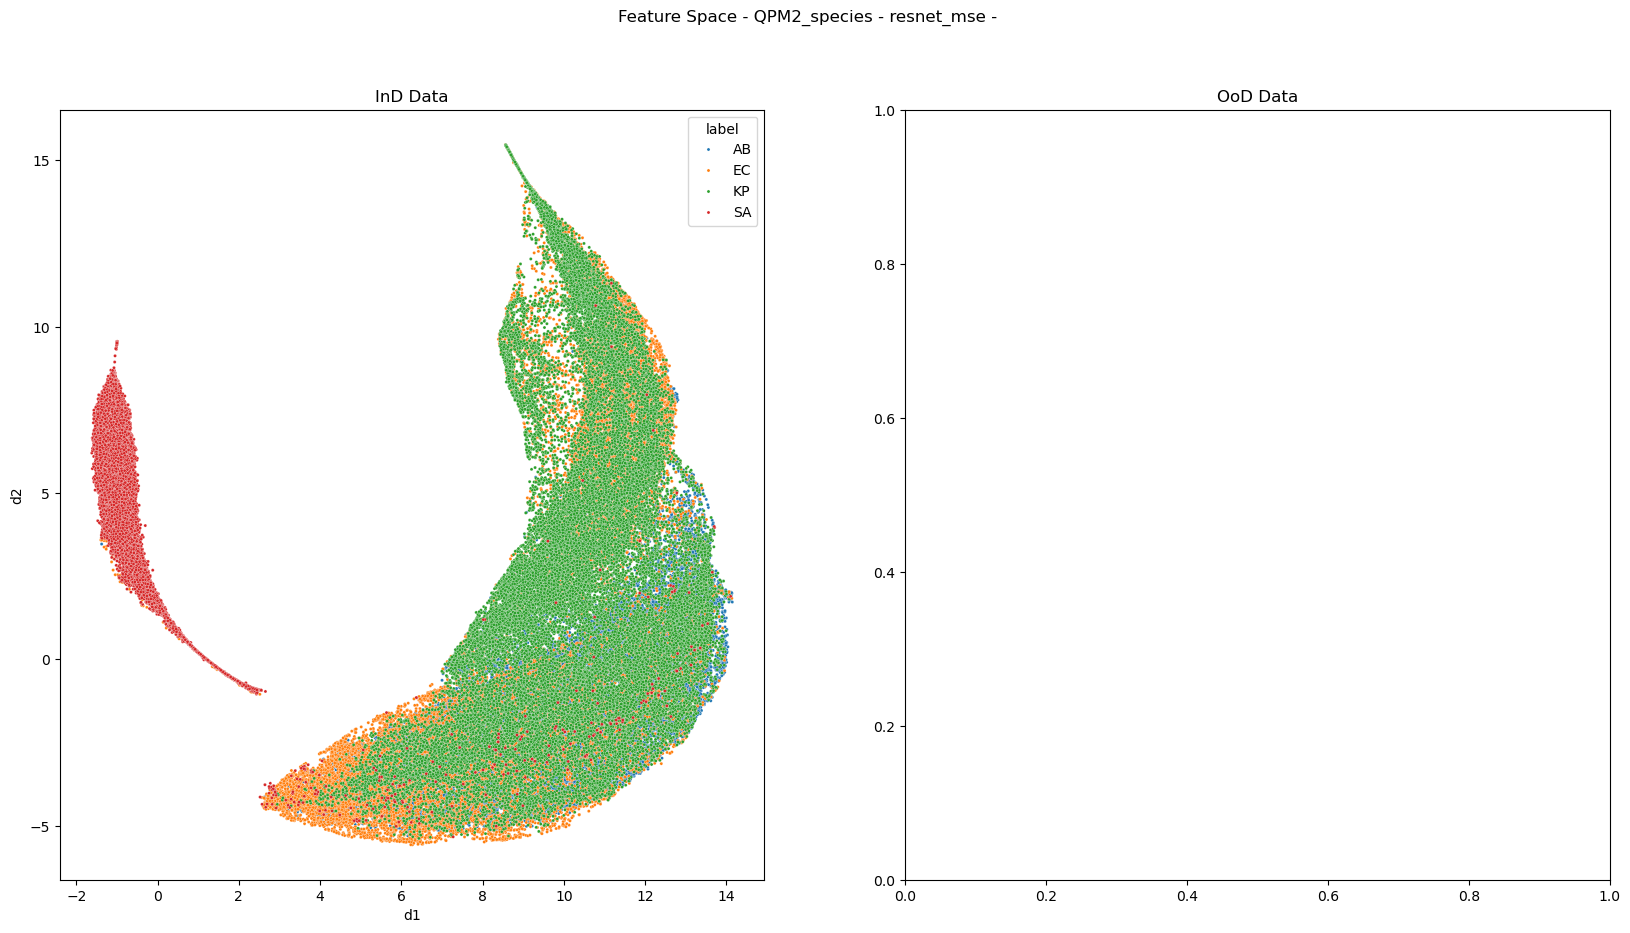

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

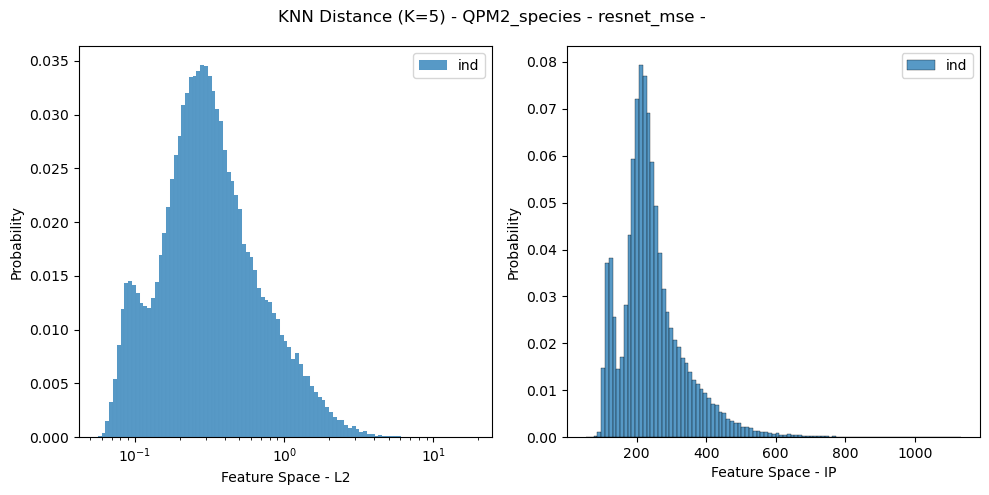

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

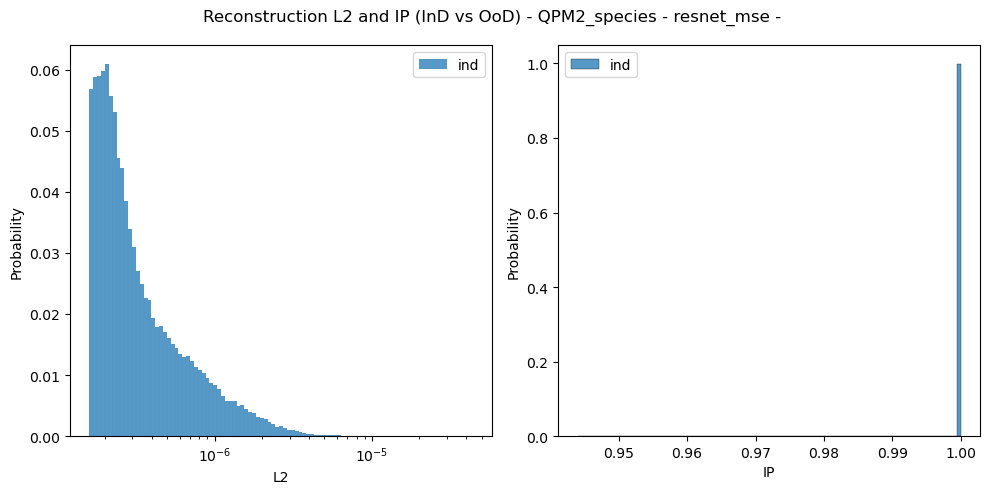

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)